In [1]:
import matplotlib.pyplot as plt
from coniferest.datasets import non_anomalous_outliers
from coniferest.label import Label
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from coniferest.label import Label
from coniferest.pineforest import PineForest
from coniferest.session import Session


In [2]:
tdes = pd.read_csv('data/rainbow_features_all_tde_in_ztf_fixed_temperature.csv')

In [3]:
tdes.shape

(27, 13)

In [4]:
tdes.keys()

Index(['objectId', 'id', 'type', 'npoints', 't0', 'amplitude', 'rise_time',
       'temperature', 'reduced_chi2', 't0_err', 'amplitude_err',
       'rise_time_err', 'temperature_err'],
      dtype='object')

In [5]:
tns = pd.read_parquet('data/tns_fixed_temp/rainbow_features_tns_201911_202103.parquet')

In [6]:
tns.shape

(316, 13)

In [7]:
tns_others = tns[tns['type'].values != 'TDE']

In [8]:
tns_others.shape

(312, 13)

In [9]:
tns_tde = tns[tns['type'].values == 'TDE']

In [10]:
simbad = pd.read_parquet('data/simbad_fixed_temp')

In [11]:
simbad.shape

(44656, 13)

In [12]:
simbad.to_csv('data/rainbow_features_all_simbad_fixed_temperature.csv')

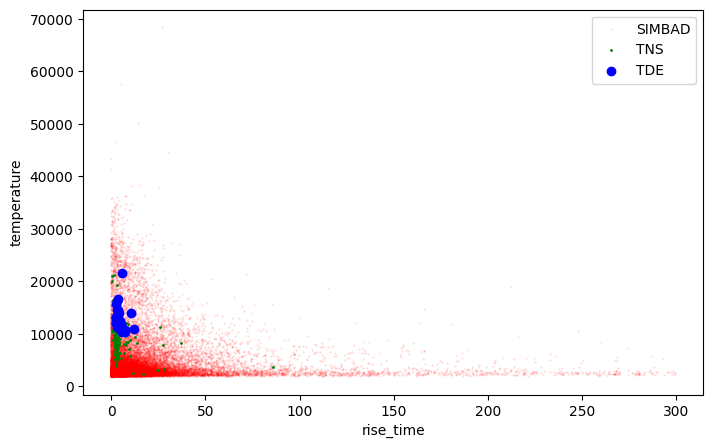

In [13]:
plt.figure(figsize=(8,5))
plt.scatter(simbad['rise_time'], simbad['temperature'], label='SIMBAD', c='r', alpha=0.1, s=0.5)
plt.scatter(tns['rise_time'], tns['temperature'], label='TNS', c='g', s=1)
plt.scatter(tdes['rise_time'], tdes['temperature'], label='TDE', color='b')

plt.xlabel('rise_time')
plt.ylabel('temperature')
plt.legend()
plt.show()

In [14]:
train_others = pd.concat([tns_others.sample(n=200, axis=0, replace=False), 
                   simbad.sample(n=2000, axis=0, replace=False)],
                 ignore_index=True)
train_others['class'] = 'inliners'

In [15]:
ntdes = 20
train_tde = tdes.sample(n=ntdes, axis=0, replace=False)
train_tde['class'] = 'outliers'

In [16]:
data_train = pd.concat([train_others, train_tde], ignore_index=True)
header = ['amplitude', 'rise_time',
       'temperature', 'reduced_chi2']#, 'amplitude_err',
       #'rise_time_err', 'temperature_err']

data_ex2 = data_train[header].values
labels_ex2 = [Label.R if item == 'inliners' else Label.A for item in data_train['class'].values]

In [17]:
model_ex2 = PineForest(n_trees=1000,
                      # Number of new tree to grow for each decision
                      n_spare_trees=5000,
                     # Fix random seed for reproducibility
                       max_depth=None,
                     random_seed=None)

from coniferest.session.callback import (
    TerminateAfter, prompt_decision_callback,
)

session_ex2 = Session(
    data_ex2,
    metadata=labels_ex2,
    model=model_ex2,
    # metadata consists of true labels,q so we can use it as a decision
    decision_callback=lambda metadata, data, session: metadata,
    on_decision_callbacks=TerminateAfter(ntdes),
)
session_ex2.run()

In [18]:
flag_tns = np.isin(tns['id'].values, data_train['id'].values)
tns_test = tns[~flag_tns][header].values

In [19]:
flag_simbad = np.isin(simbad['id'].values, data_train['id'].values)
simbad_test = simbad[~flag_simbad].sample(n=300)[header].values

In [20]:
tde_flag = np.isin(tdes['id'].values, data_train['id'].values)
tde_test = tdes[~tde_flag][header].values

In [21]:
scores_tns = session_ex2.model.score_samples(tns_test)
scores_simbad = session_ex2.model.score_samples(simbad_test)
scores_tde = session_ex2.model.score_samples(tde_test)

In [22]:
tde_test.shape

(7, 4)

In [23]:
scores_tde

array([-0.43910045, -0.48812088, -0.4831702 , -0.43258272, -0.44386835,
       -0.45791034, -0.44185081])

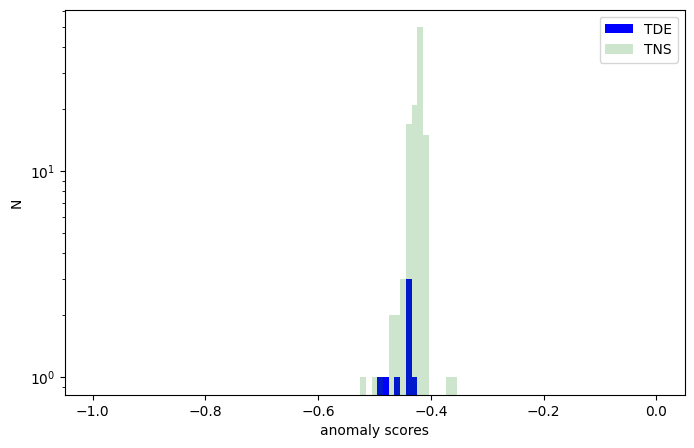

In [25]:
plt.figure(figsize=(8,5))
bin = np.linspace(-1, 0, 100)
plt.hist(scores_tde, label='TDE', alpha=1, color='blue', bins=bin)
#plt.hist(scores_simbad, label='SIMBAD', alpha=0.2, color='red', bins=bin)
plt.hist(scores_tns, label='TNS', alpha=0.2, color='green', bins=bin)
plt.xlabel('anomaly scores')
plt.ylabel('N')
plt.yscale('log')
plt.legend()
plt.show()

In [45]:
pd.DataFrame(data_ex2, columns=header)

,amplitude,rise_time,temperature,reduced_chi2
0,9.975305e+14,2.232643,8712.566779,0.297213
1,1.650356e+15,4.345471,12235.850117,0.290210
2,1.039073e+15,2.371416,9402.696829,0.175728
3,1.019470e+15,2.097147,9028.332356,0.473387
4,2.180691e+15,2.990369,9228.824468,0.079731
...,...,...,...,...
2215,1.654411e+15,2.432324,13138.712050,1.226558
2216,2.499276e+15,5.150907,11028.151254,0.687586
2217,3.269231e+15,2.242918,13214.416853,1.233047
2218,1.305218e+15,2.536838,12141.795693,1.221835
